# <a id='toc1_'></a>[Deep Neural Network for Breast Cancer Classification](#toc0_)


This tutorial demonstrates how to build and train a deep neural network for classification using the PyTorch library. The dataset used is the Breast Cancer Wisconsin (Diagnostic) Data Set.


## <a id='toc1_2_'></a>[Background](#toc0_)

**Common Uses of PyTorch**

- **Developing Deep Learning Models**: From standard feed-forward networks to complex neural networks like CNNs and RNNs.
- **Research and Experimentation**: Facilitates rapid prototyping, which is highly valued in academic and research settings.
- **Production Deployment**: With the support of TorchServe, PyTorch models can be easily transitioned from research to production environments.

## <a id='toc1_3_'></a>[Setup](#toc0_)

For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/) for managing the data.
*   [`numpy`](https://numpy.org/) for mathematical operations.
*   [`matplotlib`](https://matplotlib.org/) for additional plotting tools.
*   [`sklearn`](https://scikit-learn.org/stable/) for machine learning and machine-learning-pipeline related functions.
*   [`torch`](https://pytorch.org/) for building and training the deep neural network.
*   [`ucimlrepo`](https://pypi.org/project/ucimlrepo/) for loading the dataset.


### <a id='toc1_3_1_'></a>[Installing Required Libraries](#toc0_)


In [2]:
%pip install ucimlrepo==0.0.7

Note: you may need to restart the kernel to use updated packages.


In [40]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import torch

## <a id='toc1_4_'></a>[Load the Data](#toc0_)

### <a id='toc1_4_1_'></a>[Breast Cancer Wisconsin (Diagnostic)](#toc0_)

The [Breast Cancer Wisconsin (Diagnostic) dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) is a classic dataset used for classification tasks. It contains 569 samples of breast cancer cells, each with 30 features. The dataset is divided into two classes: benign and malignant. The goal is to classify the breast cancer cells into one of the two classes.

This dataset is free to use and is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

First, we need to load our dataset and take a look at its structure.


In [3]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

display(X.head())
display(y.head())

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,Diagnosis
0,M
1,M
2,M
3,M
4,M


Then let us check the shape of the dataset.


In [4]:
display(f'X shape: {X.shape}')
display(f'y shape: {y.shape}')

'X shape: (569, 30)'

'y shape: (569, 1)'

As we can see, the dataset has 569 samples and 30 features. The target variable is the diagnosis column, which contains the class labels for each sample. The class labels are either 'M' (malignant) or 'B' (benign).

We will then check the distribution of the target variable.


In [5]:
display(y['Diagnosis'].value_counts())

Diagnosis
B    357
M    212
Name: count, dtype: int64

Note that the dataset is **imbalanced**, with more benign samples than malignant samples. 

We will now process the data. Randomly choose 200 samples in 'M' (malignant) and 200 samples in 'B' (benign).


In [9]:
data = pd.concat([X, y], axis=1)

data_B = data[data['Diagnosis'] == 'B']
data_M = data[data['Diagnosis'] == 'M']

data_B = data_B.sample(n=200, random_state=42)
data_M = data_M.sample(n=200, random_state=42)

balanced_data = pd.concat([data_B, data_M])
display(balanced_data['Diagnosis'].value_counts())

Diagnosis
B    200
M    200
Name: count, dtype: int64

There are 200 samples in each class, with a total of 400 samples. It means that the dataset is balanced.

We will use 80% of the samples for training and 20% for testing.


## <a id='toc1_5_'></a>[Data Preprocessing](#toc0_)

Before feeding the data into our neural network, we need to preprocess it. This involves separating the features and labels, splitting the data into training and test sets, and standardizing the feature values.


In [10]:
X = balanced_data.drop('Diagnosis', axis=1)
y = balanced_data['Diagnosis']

y = y.map({'B': 0, 'M': 1})

display(X)
display(y)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
395,14.060,17.18,89.75,609.1,0.08045,0.05361,0.026810,0.03251,0.1641,0.05764,...,14.92,25.34,96.42,684.5,0.10660,0.12310,0.08460,0.07911,0.2523,0.06609
110,9.777,16.99,62.50,290.2,0.10370,0.08404,0.043340,0.01778,0.1584,0.07065,...,11.05,21.47,71.68,367.0,0.14670,0.17650,0.13000,0.05334,0.2533,0.08468
481,13.900,19.24,88.73,602.9,0.07991,0.05326,0.029950,0.02070,0.1579,0.05594,...,16.41,26.42,104.40,830.5,0.10640,0.14150,0.16730,0.08150,0.2356,0.07603
493,12.460,12.83,78.83,477.3,0.07372,0.04043,0.007173,0.01149,0.1613,0.06013,...,13.19,16.36,83.24,534.0,0.09439,0.06477,0.01674,0.02680,0.2280,0.07028
136,11.710,16.67,74.72,423.6,0.10510,0.06095,0.035920,0.02600,0.1339,0.05945,...,13.33,25.48,86.16,546.7,0.12710,0.10280,0.10460,0.06968,0.1712,0.07343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,15.320,17.27,103.20,713.3,0.13350,0.22840,0.244800,0.12420,0.2398,0.07596,...,17.73,22.66,119.80,928.8,0.17650,0.45030,0.44290,0.22290,0.3258,0.11910
328,16.270,20.71,106.90,813.7,0.11690,0.13190,0.147800,0.08488,0.1948,0.06277,...,19.28,30.38,129.80,1121.0,0.15900,0.29470,0.35970,0.15830,0.3103,0.08200
199,14.450,20.22,94.49,642.7,0.09872,0.12060,0.118000,0.05980,0.1950,0.06466,...,18.33,30.12,117.90,1044.0,0.15520,0.40560,0.49670,0.18380,0.4753,0.10130
194,14.860,23.21,100.40,671.4,0.10440,0.19800,0.169700,0.08878,0.1737,0.06672,...,16.08,27.78,118.60,784.7,0.13160,0.46480,0.45890,0.17270,0.3000,0.08701


395    0
110    0
481    0
493    0
136    0
      ..
257    1
328    1
199    1
194    1
223    1
Name: Diagnosis, Length: 400, dtype: int64

The data will be split into **80%** training and **20%** test sets.

We then print the shapes of the training and test sets to verify that the data has been split correctly.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

display(f'X_train shape: {X_train.shape}')
display(f'y_train shape: {y_train.shape}')
display(f'X_test shape: {X_test.shape}')
display(f'y_test shape: {y_test.shape}')

'X_train shape: (320, 30)'

'y_train shape: (320,)'

'X_test shape: (80, 30)'

'y_test shape: (80,)'

Then we standardize the feature values using the `StandardScaler` from scikit-learn.

Standardizing the data involves transforming the features so that they have a mean of 0 and a standard deviation of 1. This helps in ensuring that all features contribute equally to the result and helps the model converge faster during training.

1. **Fitting the Scaler**: We calculate the mean and standard deviation for each feature in the training set using the `fit` method of the `StandardScaler`.
2. **Transforming the Training Data**: We apply the standardization to the training data using the `transform` method, which scales the features accordingly.
3. **Transforming the Test Data**: We apply the same transformation to the test data using the same scaler. This ensures that both training and test sets are standardized in the same way.

By standardizing the data, we make sure that each feature contributes equally to the training process, which helps in achieving better performance and faster convergence of the neural network model.

Finally, we convert the NumPy arrays to PyTorch tensors.


In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## <a id='toc1_6_'></a>[Build and Train the Neural Network Model](#toc0_)

We will define our neural network architecture, specify the loss function and optimizer, and then train the model.

First, we define the neural network architecture using the `nn.Module` class in PyTorch. Our model consists of an input layer, one hidden layer, and an output layer with 2 neurons corresponding to the 2 classes.

Below is an example of the neural network model, it has 8 neurons in the input layer, 8 neurons in the hidden layer, and 2 neurons in the output layer.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/j-MFHvfzhrY04qVMsClOGA/8-8-2.jpg" alt="image" width="50%">


In [23]:
class ClassificationNet(nn.Module):
    def __init__(self, input_units=30, hidden_units=64, output_units=2):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(input_units, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_units)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ClassificationNet(input_units=30, hidden_units=64, output_units=2)
model

ClassificationNet(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

Then we define the loss function and optimizer. We use the `CrossEntropyLoss` loss function, which is commonly used for multi-class classification problems. The `Adam` optimizer is used to update the weights of the neural network during training.


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Then we can train the model using the training data. We iterate over the training data for a specified number of epochs and update the weights of the neural network using backpropagation.

During training, we calculate the loss at each epoch and print it to monitor the training progress. The loss should **decrease** over time as the model learns to classify the classes correctly.

Finally, we evaluate the model on the test data to see how well it performs on unseen data.


In [32]:
epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    # The `train` method sets the model to training mode, which is crucial for certain layers like Dropout and BatchNorm to behave correctly.
    # In training mode, Dropout layers randomly zero out some elements to prevent overfitting, and BatchNorm layers update their moving averages based on the current batch.
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [2/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [3/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [4/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [5/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [6/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [7/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [8/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [9/10], Train Loss: 0.6414, Test Loss: 0.6480
Epoch [10/10], Train Loss: 0.6414, Test Loss: 0.6480


## <a id='toc1_7_'></a>[Visualize the Training and Test Loss](#toc0_)

Plotting the loss curves helps us understand the training dynamics of our model.


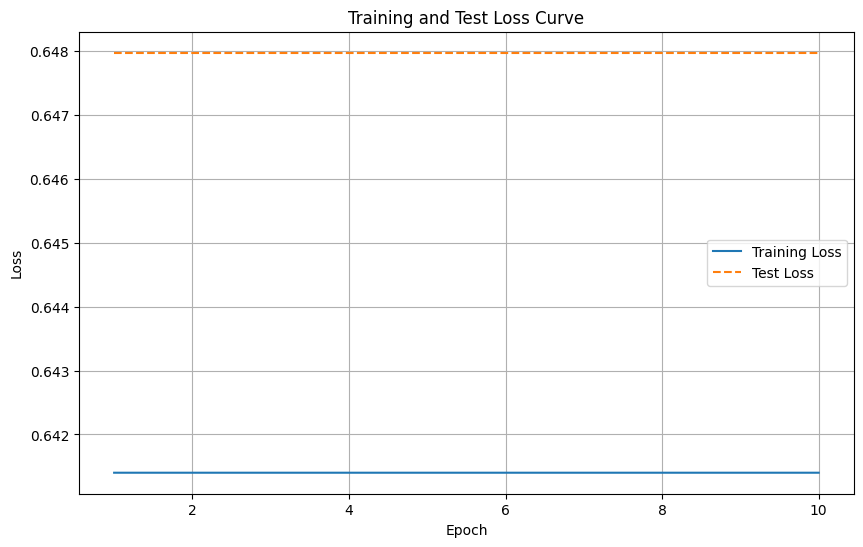

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## <a id='toc1_8_'></a>[Exercises](#toc0_)


### <a id='toc1_8_1_'></a>[Exercise 1 - Change to different optimizer: SGD](#toc0_)

Stochastic Gradient Descent (SGD) is a widely used optimization algorithm in machine learning and deep learning for training models. It is an iterative method for optimizing a loss function by making small updates to the model parameters in the direction of the negative gradient.

**How SGD Works**

SGD updates the model's parameters iteratively. The update rule for each parameter $\theta$ is as follows:

$$ \theta = \theta - \eta \cdot \nabla_\theta J(\theta) $$

where:
- $\theta$ represents the model parameters.
- $\eta$ (eta) is the learning rate, which controls the step size of each update.
- $\nabla_\theta J(\theta)$ is the gradient of the loss function with respect to the parameter $\theta$.

**PyTorch's `torch.optim.SGD`**

In PyTorch, the `torch.optim.SGD` optimizer provides several parameters to configure its behavior.

**Parameters**

1. **`params`**: 
   - The model parameters to optimize.
   - Typically provided as `model.parameters()`.

2. **`lr` (learning rate)**: 
   - A positive float value that controls the step size for each parameter update.
   - Example: `lr=0.01`.

3. **`momentum`** (optional): 
   - A float value that accelerates SGD in the relevant direction and dampens oscillations.
   - Example: `momentum=0.9`.

4. **`weight_decay`** (optional): 
   - A float value representing the L2 penalty (regularization term) to prevent overfitting.
   - Example: `weight_decay=0.0001`.

5. **`dampening`** (optional): 
   - A float value that reduces the effect of the momentum.
   - Default is `0`.

**Example Usage**

Here’s how you can use `torch.optim.SGD` with some of these parameters:

```python
import torch.optim as optim

# Define the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
```


In [34]:
model_new_optimizer = ClassificationNet(input_units=30, hidden_units=64, output_units=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_new_optimizer.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    model_new_optimizer.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_new_optimizer(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_new_optimizer.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model_new_optimizer(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/10], Train Loss: 0.5935, Test Loss: 0.5442
Epoch [2/10], Train Loss: 0.4728, Test Loss: 0.4665
Epoch [3/10], Train Loss: 0.4020, Test Loss: 0.4163
Epoch [4/10], Train Loss: 0.3532, Test Loss: 0.3800
Epoch [5/10], Train Loss: 0.3169, Test Loss: 0.3520
Epoch [6/10], Train Loss: 0.2886, Test Loss: 0.3295
Epoch [7/10], Train Loss: 0.2659, Test Loss: 0.3109
Epoch [8/10], Train Loss: 0.2471, Test Loss: 0.2951
Epoch [9/10], Train Loss: 0.2315, Test Loss: 0.2814
Epoch [10/10], Train Loss: 0.2180, Test Loss: 0.2694


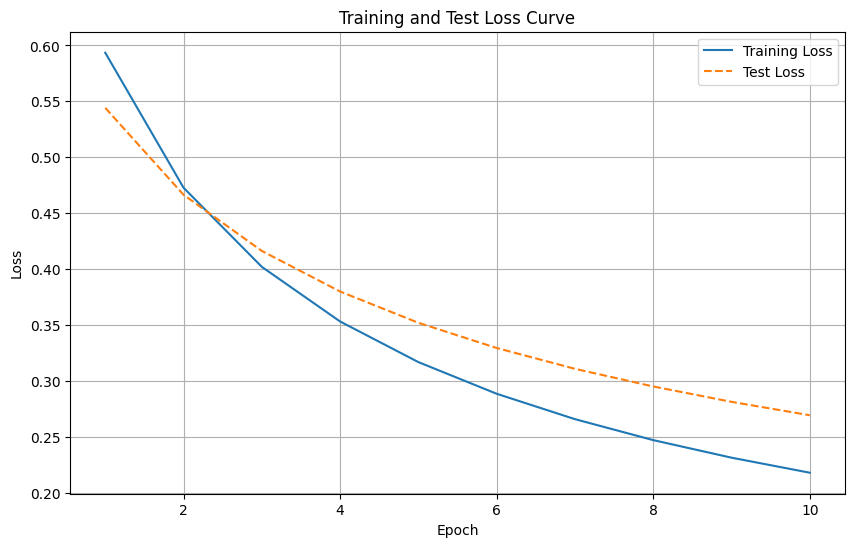

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
model_new_optimizer = ClassificationNet(input_units=30, hidden_units=64, output_units=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_new_optimizer.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    model_new_optimizer.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_new_optimizer(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_new_optimizer.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model_new_optimizer(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/10], Train Loss: 0.4069, Test Loss: 0.2556
Epoch [2/10], Train Loss: 0.1796, Test Loss: 0.1965
Epoch [3/10], Train Loss: 0.1359, Test Loss: 0.1697
Epoch [4/10], Train Loss: 0.1162, Test Loss: 0.1534
Epoch [5/10], Train Loss: 0.1040, Test Loss: 0.1416
Epoch [6/10], Train Loss: 0.0967, Test Loss: 0.1350
Epoch [7/10], Train Loss: 0.0896, Test Loss: 0.1284
Epoch [8/10], Train Loss: 0.0855, Test Loss: 0.1242
Epoch [9/10], Train Loss: 0.0816, Test Loss: 0.1210
Epoch [10/10], Train Loss: 0.0781, Test Loss: 0.1173


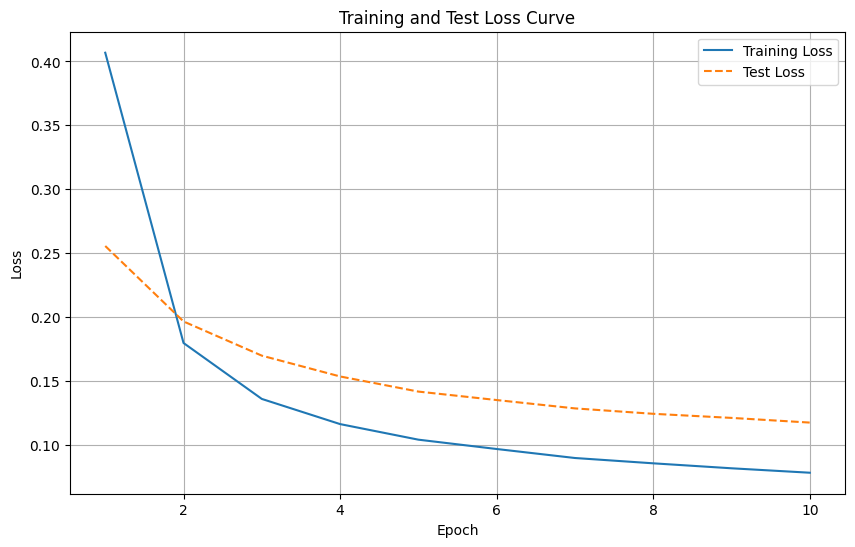

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

### <a id='toc1_8_2_'></a>[Exercise 2 - Change the number of neurons](#toc0_)

Define a new neural network architecture with different neurons and see how it affects the model's performance.


In [38]:
model_new = ClassificationNet(input_units=30, hidden_units=16, output_units=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(), lr=0.001)

epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    model_new.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_new(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_new.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model_new(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/10], Train Loss: 0.4792, Test Loss: 0.3018
Epoch [2/10], Train Loss: 0.1822, Test Loss: 0.2159
Epoch [3/10], Train Loss: 0.1286, Test Loss: 0.1764
Epoch [4/10], Train Loss: 0.1071, Test Loss: 0.1594
Epoch [5/10], Train Loss: 0.0955, Test Loss: 0.1466
Epoch [6/10], Train Loss: 0.0873, Test Loss: 0.1352
Epoch [7/10], Train Loss: 0.0811, Test Loss: 0.1302
Epoch [8/10], Train Loss: 0.0752, Test Loss: 0.1271
Epoch [9/10], Train Loss: 0.0727, Test Loss: 0.1178
Epoch [10/10], Train Loss: 0.0679, Test Loss: 0.1171


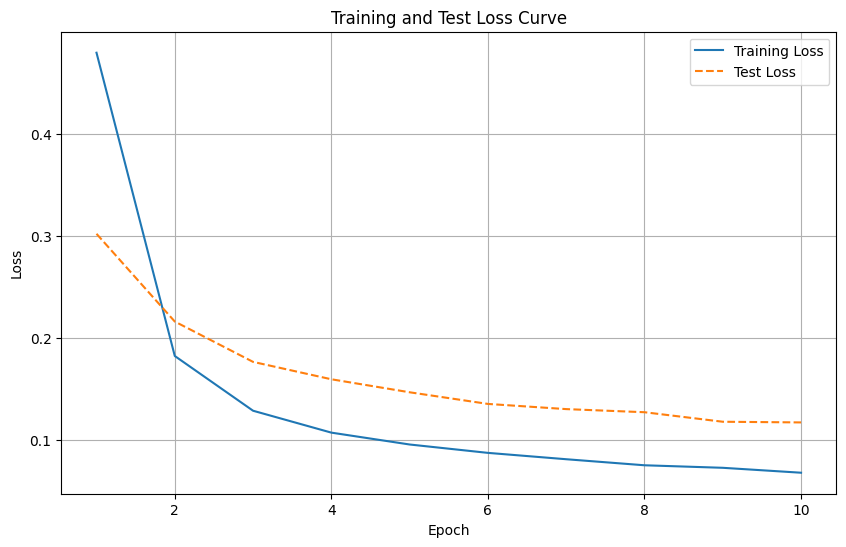

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

### <a id='toc1_8_3_'></a>[Exercise 3 - Try different dataset - Iris Dataset](#toc0_)

Try using the [Iris dataset](https://archive.ics.uci.edu/dataset/53/iris) for classification. The Iris dataset is a classic dataset used for classification tasks. It contains 150 samples of iris flowers, each with 4 features. The dataset is divided into three classes, with each class representing a different species of iris flower. The goal is to classify the iris flowers into one of the three classes.

This dataset is free to use and is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

You can load the Iris dataset using the following code:

```python
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()

# Extract the features and target variable
X_iris = iris.data
y_iris = iris.target
```

You can then preprocess the data, build and train the neural network model, and evaluate its performance on the test set.


Epoch [1/10], Train Loss: 1.2000, Test Loss: 1.1240
Epoch [2/10], Train Loss: 1.0523, Test Loss: 0.9806
Epoch [3/10], Train Loss: 0.9091, Test Loss: 0.8467
Epoch [4/10], Train Loss: 0.7903, Test Loss: 0.7284
Epoch [5/10], Train Loss: 0.6769, Test Loss: 0.6297
Epoch [6/10], Train Loss: 0.5796, Test Loss: 0.5515
Epoch [7/10], Train Loss: 0.4999, Test Loss: 0.4929
Epoch [8/10], Train Loss: 0.4507, Test Loss: 0.4528
Epoch [9/10], Train Loss: 0.4089, Test Loss: 0.4226
Epoch [10/10], Train Loss: 0.3764, Test Loss: 0.3989


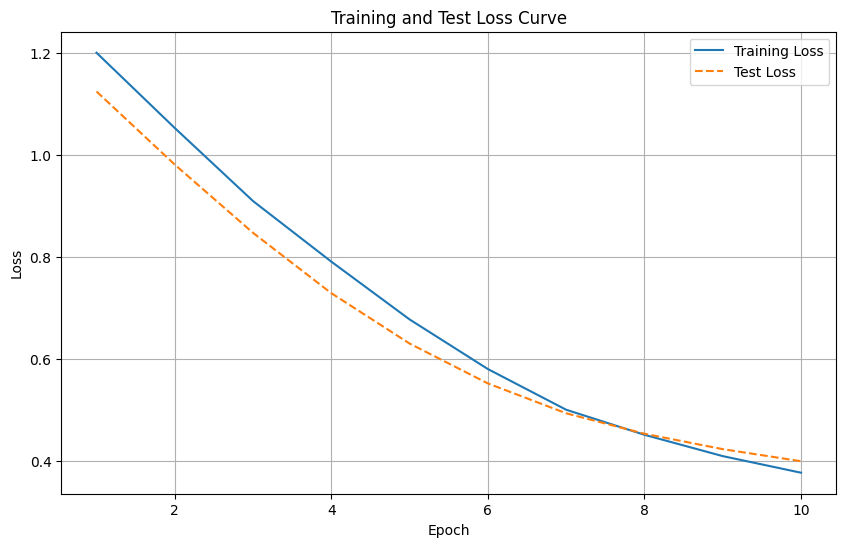

In [84]:
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ClassificationNet(input_units=4, hidden_units=8, output_units=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()